# Classification: Predicting Net Inflow and Outflow

After trying to predict the migration rates as a regression problem, we wondered if our model would be better if we treated it as a classification problem. Specifically, we encoded the migrations rates into two classes: 0 for net outflow (negative rate) and 1 for net inflow (positive rate).

In [1]:
import classification as cl
import pandas as pd
import numpy as np

In [2]:
# load data
df = pd.read_csv("/Users/rainie/Downloads/PIC_16B/Project/final_merged_data.csv")

# split into features and labels, preview data
X, y = cl.clean(df)

In [3]:
# check the proportions of each class in the original data
prop0 = np.sum(y == 0)/np.size(y)
prop1 = np.sum(y == 1)/np.size(y)
print(f'class 0 proportion: {prop0: .4f}')
print(f'class 1 proportion: {prop1: .4f}') # more class 1 than class 0, imbalanced dataset

class 0 proportion:  0.4480
class 1 proportion:  0.5520


We know that the classes are inbalanced in our data, so for the model to better predict inflow/outflow, we try to adjust the threshold. From the proportions, it is reasonable to set a threshold of 0.4480 instead of the 0.5, meaning that there should be a higher likelihood of predicting a net inflow (class 1). We also tested other thresholds, but as expected, they would not be fitting for our dataset.

In [4]:
# show class weights, these are already added as parameter since classes are imbalanced
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y)
print(dict(zip([0, 1], class_weights)))

{0: 1.1161616161616161, 1: 0.9057377049180327}


## Modeling

Our modeling pipeline includes baseline and advanced models, evaluation using multiple metrics, and adjustments to address class imbalance and overfitting.

### Models Used

1. Random Forest: An ensemble of decision trees trained on bootstrapped data. It captures non-linear patterns and reduces overfitting through averaging.

2. XGBoost: A gradient boosting framework that builds trees sequentially to fix errors from earlier trees, often achieving high accuracy. 

3. Logistic Regression: A simple and interpretable linear classifier that outputs probabilities. Useful as a baseline.

4. Ensemble Models: A combination of the above models using VotingClassifier.

*Note: We do not use SVM because it does not directly provide probability outputs, which are important for evaluating threshold-based performance.*

### Model Adjustments and Tuning

To ensure fair and robust evaluation, we apply the following techniques:

1. Cross-Validation & Hyperparameter Tuning

    We use GridSearchCV to perform K-fold cross-validation, which tests multiple combinations of hyperparameters and helps reduce overfitting.
    - Example hyperparameters:
        - `n_estimators`, `max_depth` for Random Forest
        - `learning_rate`, `subsample`, `max_depth` for XGBoost

2. Class Weights

    Our data may be imbalanced (e.g., more states have net inflow). To handle this, we assign higher weight to the minority class (class 0) during training. This helps improve recall and F1 score for net outflow predictions.

3. Threshold Tuning

    Logistic models and tree-based classifiers return probabilities for each class. By default, a threshold of 0.5 is used to assign labels. We adjust this threshold (e.g., to 0.448) based on validation set performance to optimize for F1 score or precision/recall balance.

### Model Evaluation

Each model is run multiple times with different random splits to account for variance and produce stable performance metrics. We report the **average accuracy** and **F1 score** across runs.

#### Confusion Matrix

The confusion matrix summarizes how well a model performs:

|                | **Predicted: 0** | **Predicted: 1** |
|----------------|------------------|------------------|
| **Actual: 0**  | True Negative (TN) | False Positive (FP) |
| **Actual: 1**  | False Negative (FN) | True Positive (TP) |

From this matrix, we calculate:

- **Accuracy**:  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Precision**:  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall**:  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **F1 Score**:  
  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

These metrics help assess performance beyond raw accuracy, especially important in **imbalanced datasets**.

## Random Forest


In [5]:
# prepare data
X_train, X_test, y_train, y_test = cl.data_prep(X, y)

# parameter tuning
rf_best = cl.rf_param_select(X_train, y_train)

Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


Evaluation for Random Forest at threshold = 0.5
Accuracy: 0.6466165413533834


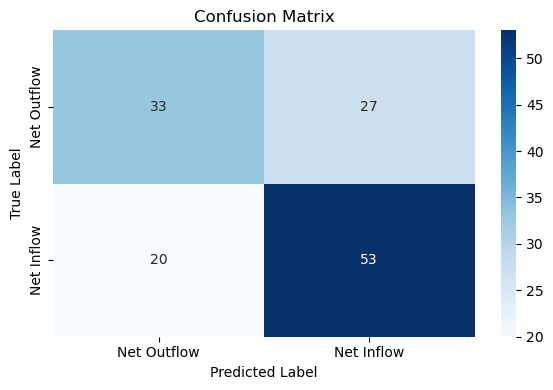

              precision    recall  f1-score   support

 Net Outflow       0.62      0.55      0.58        60
  Net Inflow       0.66      0.73      0.69        73

    accuracy                           0.65       133
   macro avg       0.64      0.64      0.64       133
weighted avg       0.64      0.65      0.64       133

Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Average Accuracy for Random Forest over 5 runs: 0.7820


In [6]:
# train and evaluate
# threshold = 0.5 (default)
y_pred_rf = cl.evaluate_model(rf_best, X_test, y_test, threshold=0.5, name='Random Forest')

# run multiple times and get average accuracy
rf_acc1 = cl.repeat_eval(X, y, model_fn=cl.rf_param_select, threshold=0.5, name="Random Forest", repeats=5)

Evaluation for Random Forest at threshold = 0.448
Accuracy: 0.6616541353383458


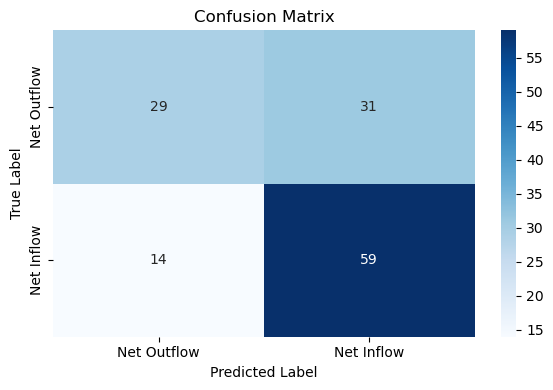

              precision    recall  f1-score   support

 Net Outflow       0.67      0.48      0.56        60
  Net Inflow       0.66      0.81      0.72        73

    accuracy                           0.66       133
   macro avg       0.66      0.65      0.64       133
weighted avg       0.66      0.66      0.65       133

Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Average Accuracy for Random Forest over 5 runs: 0.7865


In [7]:
# threshold = 0.448 (based on dataset composition)
y_pred_rf = cl.evaluate_model(rf_best, X_test, y_test, threshold=0.448, name='Random Forest')

# run multiple times and get average accuracy
rf_acc2 = cl.repeat_eval(X, y, model_fn=cl.rf_param_select, threshold=0.448, name="Random Forest", repeats=5)

The adjusted threshold for Random Forest performs slightly better than the original threshold of 0.5. Overall, this model has an accuracy of around 78%.

## XGBoost

In [8]:
# parameter tuning
xgb_best = cl.xgb_param_select(X_train, y_train)

Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}


Evaluation for XGBoost at threshold = 0.5
Accuracy: 0.6766917293233082


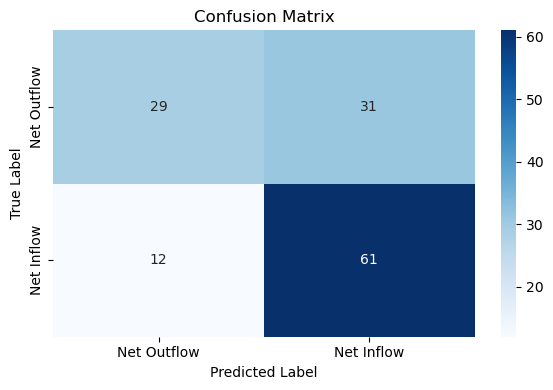

              precision    recall  f1-score   support

 Net Outflow       0.71      0.48      0.57        60
  Net Inflow       0.66      0.84      0.74        73

    accuracy                           0.68       133
   macro avg       0.69      0.66      0.66       133
weighted avg       0.68      0.68      0.66       133

Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Average Accuracy for XGBoost over 5 runs: 0.7744


In [9]:
# train and evaluate
# threshold = 0.5 (default)
y_pred_xgb = cl.evaluate_model(xgb_best, X_test, y_test, threshold=0.5, name='XGBoost')

# run multiple times and get average accuracy
xgb_acc1 = cl.repeat_eval(X, y, model_fn=cl.xgb_param_select, threshold=0.5, name="XGBoost", repeats=5)

Evaluation for XGBoost at threshold = 0.448
Accuracy: 0.6917293233082706


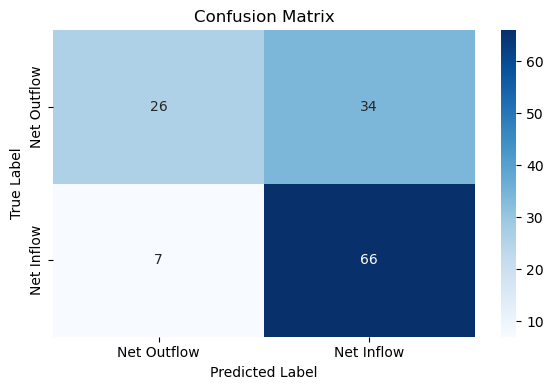

              precision    recall  f1-score   support

 Net Outflow       0.79      0.43      0.56        60
  Net Inflow       0.66      0.90      0.76        73

    accuracy                           0.69       133
   macro avg       0.72      0.67      0.66       133
weighted avg       0.72      0.69      0.67       133

Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Average Accuracy for XGBoost over 5 runs: 0.7594


In [10]:
# threshold = 0.448 (based on dataset composition)
y_pred_xgb = cl.evaluate_model(xgb_best, X_test, y_test, threshold=0.448, name='XGBoost')

# run multiple times and get average accuracy
xgb_acc2 = cl.repeat_eval(X, y, model_fn=cl.xgb_param_select, threshold=0.448, name="XGBoost", repeats=5)

The original threshold performs better for XGBoost, at around 77.44% compared to the 75.94% by the adjusted threshold. This model performs slightly worse than Random Forest.

## Logistic Regression

In [11]:
# parameter tuning
lr_best = cl.lr_param_select(X_train, y_train)

Best Logistic Regression Params: {'C': 10, 'penalty': 'l1'}


Evaluation for Logistic Regression at threshold = 0.5
Accuracy: 0.6466165413533834


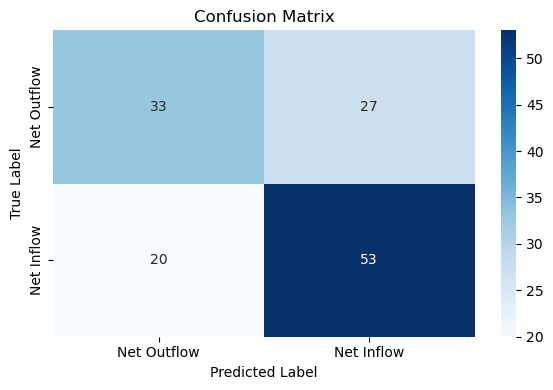

              precision    recall  f1-score   support

 Net Outflow       0.62      0.55      0.58        60
  Net Inflow       0.66      0.73      0.69        73

    accuracy                           0.65       133
   macro avg       0.64      0.64      0.64       133
weighted avg       0.64      0.65      0.64       133

Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}

Average Accuracy for Logistic Regression over 5 runs: 0.5579


In [12]:
# train and evaluate
# threshold = 0.5 (default)
y_pred_lr = cl.evaluate_model(lr_best, X_test, y_test, threshold=0.5, name='Logistic Regression')

# run multiple times and get average accuracy
lr_acc1 = cl.repeat_eval(X, y, model_fn=cl.lr_param_select, threshold=0.5, name="Logistic Regression", repeats=5)

Evaluation for Logistic Regression at threshold = 0.448
Accuracy: 0.706766917293233


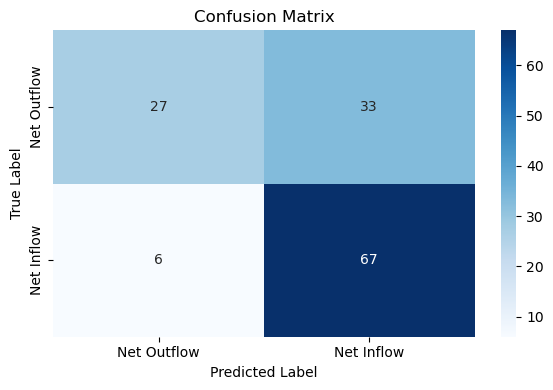

              precision    recall  f1-score   support

 Net Outflow       0.82      0.45      0.58        60
  Net Inflow       0.67      0.92      0.77        73

    accuracy                           0.71       133
   macro avg       0.74      0.68      0.68       133
weighted avg       0.74      0.71      0.69       133

Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1'}

Average Accuracy for Logistic Regression over 5 runs: 0.5970


In [13]:
# threshold = 0.448 (based on dataset composition)
y_pred_lr = cl.evaluate_model(lr_best, X_test, y_test, threshold=0.448, name='Logistic Regression')

# run multiple times and get average accuracy
lr_acc2 = cl.repeat_eval(X, y, model_fn=cl.lr_param_select, threshold=0.448, name="Logistic Regression", repeats=5)

Logistic regression performs the worst out of the three models, likely because it is a linear model and our data is nonlinear. Nevertheless, the adjusted threshold gives an accuracy of 59.70%, an improvement from the original threshold of 55.79%.

## Ensemble Model using Voting Classifier

In [14]:
# define all models (best ones from before)
rf = rf_best
xgb = xgb_best
lr = lr_best

Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best Logistic Regression Params: {'C': 10, 'penalty': 'l1'}
Evaluation for RF + XGB + LR Ensemble at threshold = 0.5
Accuracy: 0.6842105263157895


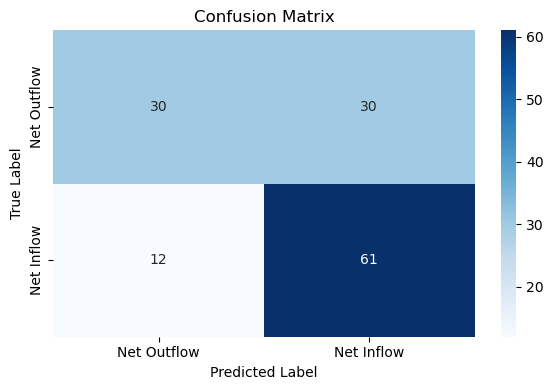

              precision    recall  f1-score   support

 Net Outflow       0.71      0.50      0.59        60
  Net Inflow       0.67      0.84      0.74        73

    accuracy                           0.68       133
   macro avg       0.69      0.67      0.67       133
weighted avg       0.69      0.68      0.67       133



In [15]:
# ensemble model with all
# weights 2, 2, 1 - put less weight on the logistic regression model
ensemble = cl.make_ensemble_model(X_train, y_train,
                               use_rf=True, use_xgb=True, use_lr=True,
                               weights=[2, 2, 1])
# train the ensemble model
ensemble.fit(X_train, y_train)

# evaluate using the function as before - threshold 0.5
y_pred_en1 = cl.evaluate_model(ensemble, X_test, y_test, threshold=0.5, name="RF + XGB + LR Ensemble")

# # get reusable model function
# model_fn = cl.get_ensemble_model_fn(use_rf=True, use_xgb=True, use_lr=True, weights=[2, 2, 1])

# # run repeat evaluation to get average accuracy - threshold 0.5
# ensemble1_acc1 = cl.repeat_eval(X, y, model_fn=model_fn, threshold=0.5, name="RF + XGB + LR Ensemble", repeats=5)

Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best Logistic Regression Params: {'C': 10, 'penalty': 'l1'}
Evaluation for RF + XGB + LR Ensemble at threshold = 0.448
Accuracy: 0.6766917293233082


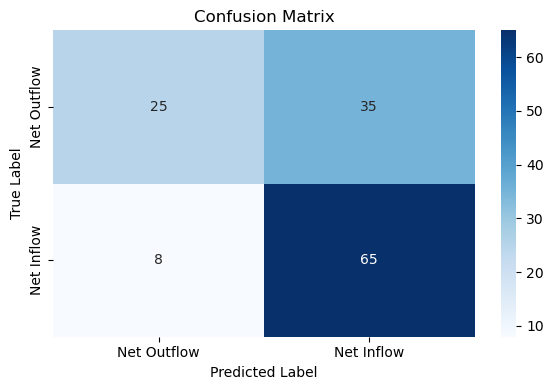

              precision    recall  f1-score   support

 Net Outflow       0.76      0.42      0.54        60
  Net Inflow       0.65      0.89      0.75        73

    accuracy                           0.68       133
   macro avg       0.70      0.65      0.64       133
weighted avg       0.70      0.68      0.65       133



In [16]:
# ensemble model with all
# weights 2, 2, 1 - put less weight on the logistic regression model
ensemble = cl.make_ensemble_model(X_train, y_train,
                               use_rf=True, use_xgb=True, use_lr=True,
                               weights=[2, 2, 1])
# train the ensemble model
ensemble.fit(X_train, y_train)

# evaluate using the function as before - threshold 0.448
y_pred_en2 = cl.evaluate_model(ensemble, X_test, y_test, threshold=0.448, name="RF + XGB + LR Ensemble")

# # get reusable model function
# model_fn = cl.get_ensemble_model_fn(use_rf=True, use_xgb=True, use_lr=True, weights=[2, 2, 1])

# # run repeat evaluation to get average accuracy - threshold 0.448
# ensemble1_acc2 = cl.repeat_eval(X, y, model_fn=model_fn, threshold=0.448, name="RF + XGB + LR Ensemble", repeats=5)

Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Evaluation for RF + XGB Ensemble at threshold = 0.5
Accuracy: 0.6691729323308271


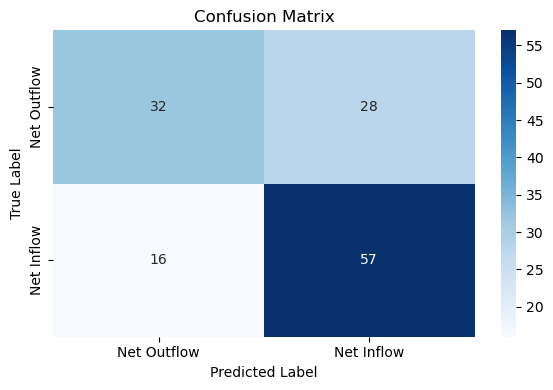

              precision    recall  f1-score   support

 Net Outflow       0.67      0.53      0.59        60
  Net Inflow       0.67      0.78      0.72        73

    accuracy                           0.67       133
   macro avg       0.67      0.66      0.66       133
weighted avg       0.67      0.67      0.66       133



In [17]:
# ensemble model with only random forest and xgboost 
ensemble = cl.make_ensemble_model(X_train, y_train, use_rf=True, use_xgb=True, use_lr=False)

# train the ensemble model
ensemble.fit(X_train, y_train)

# evaluate using the function as before
y_pred_en3 = cl.evaluate_model(ensemble, X_test, y_test, threshold=0.5, name="RF + XGB Ensemble")

# # run repeat evaluation to get average accuracy
# ensemble2_acc1 = cl.repeat_eval(X, y, model_fn=ensemble, threshold=0.5, name="RF + XGB Ensemble", repeats=5)

Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Evaluation for RF + XGB Ensemble at threshold = 0.448
Accuracy: 0.6766917293233082


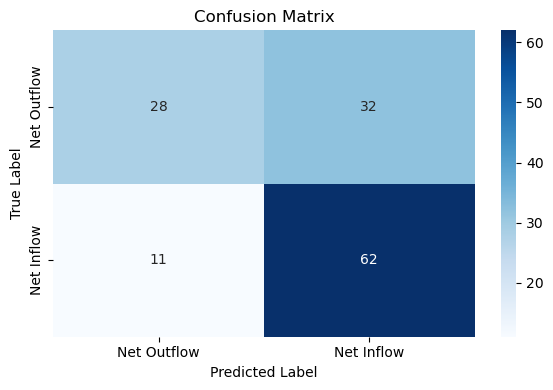

              precision    recall  f1-score   support

 Net Outflow       0.72      0.47      0.57        60
  Net Inflow       0.66      0.85      0.74        73

    accuracy                           0.68       133
   macro avg       0.69      0.66      0.65       133
weighted avg       0.69      0.68      0.66       133



In [18]:
# ensemble model with only random forest and xgboost 
ensemble = cl.make_ensemble_model(X_train, y_train, use_rf=True, use_xgb=True, use_lr=False)

# train the ensemble model
ensemble.fit(X_train, y_train)

# evaluate using the function as before
y_pred_en4 = cl.evaluate_model(ensemble, X_test, y_test, threshold=0.448, name="RF + XGB Ensemble")

# # run repeat evaluation to get average accuracy
# ensemble2_acc2 = cl.repeat_eval(X, y, model_fn=ensemble, threshold=0.448, name="RF + XGB Ensemble", repeats=5)